In [17]:
import sys
sys.path.append('/global/home/users/nathan_sandford/D-Payne')

from __future__ import absolute_import, division, print_function
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import multiprocessing
import utils

'''
Code for reading in 1-d DEIMOS spectra reduced by the spec2d code:
http://deep.ps.uci.edu/spec2d/.

This code:
1) Reads in 1-d DEIMOS spectra .fits files and concatenates spectra from the
red and blue CCDs.
2) Interpolates spectra onto the standard wavelength template for DEIMOS.
3) Outputs all object spectra in a .npz file.
'''

# # # Settings # # #

'''
Which method of fitting the DEIMOS spectrum do you want to use:
'Horne' or 'Bxspf'
'''
method = 'Horne'

# Directory reduced DEIMOS spectra reside in
DEIMOSDir = '/global/scratch/nathan_sandford/DEIMOS/'
InputDir = DEIMOSDir + 'U112/m15msk/m15msk/'
# Input List of DEIMOS spectra to be processed for fitting
InputList = InputDir + 'spec1d.m15msk.txt'
# D-Payne Directory
D_PayneDir = utils.D_PayneDir
# Output directory for processed spectra
OutputDir = D_PayneDir + 'spectra/M15/'
# File containing processed spectra
OutputFile = 'm15_'+method+'_ipynb.npz'

# Extract object names from input list
print('Restoring list of objects...')
temp = open(InputList, 'r')
ObjList = temp.read().split('\n')[:-2]
ObjList = ObjList[:] # Any subset of objects?
temp.close

# Restore Wavelength Template
print('Restoring Wavelength Template...')
wavelength_template = utils.load_wavelength_array()

# Calculate matrix of distances between wavelengths
print('Calculating matrix of distances between wavelengths...')
wavelength_diff_matrix \
    = wavelength_template[:, np.newaxis] - wavelength_template
    
# Restore DEIMOS continuum pixels
print('Restoring DEIMOS continuum pixels...')
cont_reg = utils.load_deimos_cont_pixels()

# Restore spectral mask from Kirby+ 2008
print('Restoring spectral mask from Kirby+ 2008...')
kirby_2008_telluric = utils.get_spectral_mask_dict(name='kirby_2008_telluric')
mask = utils.generate_mask_from_dict(**kirby_2008_telluric)

# Restore spectral template of typical RGB star
print('Restoring spectral template...')
temp = np.load(D_PayneDir + '/other_data/typical_RGB_spectra.npz')
template_spec = temp['spec'][(wavelength_template > 8450) & (wavelength_template < 8700)]
temp.close()
wavelength_CaIItriplet = wavelength_template[(wavelength_template > 8450) & (wavelength_template < 8700)]
dv_grid = np.linspace(-300,300,300)
template_grid = np.empty((len(dv_grid),len(wavelength_CaIItriplet)))
for i,dv in enumerate(dv_grid):
    template_grid[i] = utils.doppler_shift(wavelength_CaIItriplet,template_spec,dv)


def get_deimos_spectra(Obj, method, InputDir=None):
    '''
    Read in and concatenate red and blue spectra
    '''
    ObjHDUL = fits.open(InputDir + Obj)

    waveB = ObjHDUL[method+'-B'].data['LAMBDA'][0]
    waveR = ObjHDUL[method+'-R'].data['LAMBDA'][0]
    wave = np.concatenate((waveB, waveR))

    specB = ObjHDUL[method+'-B'].data['SPEC'][0]
    specR = ObjHDUL[method+'-R'].data['SPEC'][0]
    spec = np.concatenate((specB, specR))

    ivarB = ObjHDUL[method+'-B'].data['IVAR'][0]
    ivarB = 1e-16 * np.ones(len(ivarB)) # completely ignore blue channel
    ivarR = ObjHDUL[method+'-R'].data['IVAR'][0]
    ivar = np.concatenate((ivarB, ivarR))
    ivar[ivar == 0] = 1e-16  # Avoid np.inf in spec_err

    RA = ObjHDUL[method+'-B'].header['RA_OBJ']
    Dec = ObjHDUL[method+'-B'].header['DEC_OBJ']
    return (wave, spec, ivar, RA, Dec)


def interpolate_deimos_spectra(wave, spec, spec_err):
    '''
    Interpolates a DEIMOS spectrum onto the default wavelength grid
    '''
    if len(wave) != 16250:
        spec = np.interp(wavelength_template, wave, spec)
        spec_err = np.interp(wavelength_template, wave, spec_err)
        wave = np.copy(wavelength_template)
    return(wave, spec, spec_err)


def fast_RV(spec, spec_err, plot=False):
    '''
    Quick radial velocity determination by cross-correlating observed spectrum
    with a template spectrum in the region around the Ca II triplet. 
    '''
    
    # Consider only region around Ca II triplet
    temp_spec = spec[(wavelength_template > 8450) & (wavelength_template < 8700)]
    temp_spec_err = spec_err[(wavelength_template > 8450) & (wavelength_template < 8700)]
    
    # Cross-Correlate
    num = np.sum(template_grid * temp_spec / temp_spec_err**2, axis=1)
    den = np.sum(template_grid * template_grid / temp_spec_err**2, axis=1)
    xcorr = num / den
    
    # Naively take maximum of CCF
    dv = dv_grid[np.argmax(xcorr)]
    
    # Plot output
    if plot:
        plt.plot(dv_grid,xcorr)
        plt.xlabel('RV (km/s)')
        plt.ylabel('Cross-Corellation')
        plt.show()
    
    return(dv)


def process_deimos_spectra(i):
    '''
    Processes all spectra in InputList
    '''
    Obj = ObjList[i]
    ObjNumber = Obj[14:-5]
    print('Processing spectra for object: %s' % Obj)
    
    print('Restoring spectra #%s' % ObjNumber)
    wave_temp, spec_temp, ivar_temp, RA, Dec = \
        get_deimos_spectra(Obj=Obj, method=method, InputDir=InputDir)
        
    print('Interpolating spectra #%s' % ObjNumber)
    wavelength, spec, spec_err = \
        interpolate_deimos_spectra(wave=wave_temp,
                                   spec=spec_temp,
                                   spec_err=(ivar_temp**-1))
    
    print('Applying telluric mask for spectra %s' % ObjNumber)
    spec_err[mask] = 1e16
                                   
    print('Finding radial velocity from CCF for spectra #%s' % ObjNumber)
    dv = fast_RV(spec, spec_err, plot=False)
    print('%s has Radial Velocity = %.0f' % (ObjNumber,dv))
    print('Shifting spectra %s to rest frame' % ObjNumber)
    spec = utils.doppler_shift(wavelength=wavelength, flux=spec, dv=-dv)
    
    print('Normalizing spectra %s' % ObjNumber)
    cont_spec = \
        utils.get_deimos_continuum(spec, spec_err=spec_err,
                                   wavelength=wavelength,
                                   cont_pixels=cont_reg,
                                   wavelength_diff_matrix=wavelength_diff_matrix)
    spec = spec / cont_spec
    
    # Handle regions where continuum is zero
    spec_err[np.isnan(spec)] = 1e16
    spec[np.isnan(spec)] = 0
    
    return(ObjNumber, wavelength, spec, spec_err, dv, RA, Dec)


print('Beginning processing of all spectra')
pool = multiprocessing.Pool(multiprocessing.cpu_count())
temp = pool.map(process_deimos_spectra, range(len(ObjList)))
temp = list(zip(*temp))
ObjNumber, wavelength, spec, spec_err, dv, RA, Dec = temp
print('Completed processing of all spectra')

# Save processed spectra
print('Saving all processed spectra to %s' % OutputFile)
np.savez(OutputDir + OutputFile, obj=ObjNumber, wavelength=wavelength,
         spec=spec, spec_err=spec_err, dv=dv, RA=RA, Dec=Dec)


Restoring list of objects...
Restoring Wavelength Template...
Calculating matrix of distances between wavelengths...
Restoring DEIMOS continuum pixels...
Restoring spectral mask from Kirby+ 2008...
Restoring spectral template...
Beginning processing of all spectra
Processing spectra for object: spec1d.m15msk.001.0000014.fits
Restoring spectra #000.0000006
Processing spectra for object: spec1d.m15msk.000.0000006.fits
Restoring spectra #001.0000014
Processing spectra for object: spec1d.m15msk.005.0000030.fits
Processing spectra for object: spec1d.m15msk.004.0000029.fits
Processing spectra for object: spec1d.m15msk.008.serendip1.fits
Processing spectra for object: spec1d.m15msk.008.0010337.fits
Restoring spectra #008.serendip1
Processing spectra for object: spec1d.m15msk.015.0010330.fits
Restoring spectra #004.0000029
Restoring spectra #008.0010337
Restoring spectra #015.0010330
Processing spectra for object: spec1d.m15msk.020.0010068.fits
Processing spectra for object: spec1d.m15msk.015.

Applying telluric mask for spectra 010.0010510
Applying telluric mask for spectra 003.0000023
Calculating weights...
Finding radial velocity from CCF for spectra #012.0010152
Normalizing spectra 001.0000014
025.0010581 has Radial Velocity = -57
021.0010093 has Radial Velocity = -170
Normalizing spectra 008.serendip1
Finding radial velocity from CCF for spectra #024.serendip2
Finding radial velocity from CCF for spectra #007.0000034
Finding radial velocity from CCF for spectra #014.0010260
Normalizing spectra 015.serendip2
Applying telluric mask for spectra 028.0010147
Finding radial velocity from CCF for spectra #003.0000023
Applying telluric mask for spectra 024.0010453
Shifting spectra 025.0010581 to rest frame
Shifting spectra 021.0010093 to rest frame
Finding radial velocity from CCF for spectra #010.0010510
Interpolating spectra #016.serendip1
Calculating weights...
Calculating weights...
Finding radial velocity from CCF for spectra #029.serendip1
Calculating weights...
Finding ra

/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.030.0010442.fits
Restoring spectra #030.0010442


/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Continuum calculation complete!


/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Interpolating spectra #030.0010442
Processing spectra for object: spec1d.m15msk.030.serendip1.fits
Processing spectra for object: spec1d.m15msk.031.0010425.fits
Applying telluric mask for spectra 030.0010442
Finding radial velocity from CCF for spectra #030.0010442
Restoring spectra #030.serendip1
Restoring spectra #031.0010425
Continuum calculation complete!
030.0010442 has Radial Velocity = -139
Shifting spectra 030.0010442 to rest frame


/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Normalizing spectra 030.0010442
Calculating weights...
Processing spectra for object: spec1d.m15msk.031.serendip1.fits
Restoring spectra #031.serendip1
Interpolating spectra #031.serendip1
Interpolating spectra #031.0010425
Interpolating spectra #030.serendip1
Applying telluric mask for spectra 030.serendip1
Finding radial velocity from CCF for spectra #030.serendip1
Applying telluric mask for spectra 031.0010425
Applying telluric mask for spectra 031.serendip1
Finding radial velocity from CCF for spectra #031.0010425
Finding radial velocity from CCF for spectra #031.serendip1
030.serendip1 has Radial Velocity = 278
031.serendip1 has Radial Velocity = -79
031.0010425 has Radial Velocity = -172
Shifting spectra 031.0010425 to rest frame
Shifting spectra 031.serendip1 to rest frame
Continuum calculation complete!
Shifting spectra 030.serendip1 to rest frame
Normalizing spectra 030.serendip1
Normalizing spectra 031.0010425
Normalizing spectra 031.serendip1
Calculating weights...
Calculati

/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.032.0010123.fits
Continuum calculation complete!
Restoring spectra #032.0010123
Continuum calculation complete!
Processing spectra for object: spec1d.m15msk.033.0010107.fits
Interpolating spectra #031.serendip2
Restoring spectra #033.0010107
Applying telluric mask for spectra 031.serendip2
Continuum calculation complete!
Finding radial velocity from CCF for spectra #031.serendip2
Processing spectra for object: spec1d.m15msk.034.0010494.fits
Continuum calculation complete!


/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Restoring spectra #034.0010494
031.serendip2 has Radial Velocity = 226
Processing spectra for object: spec1d.m15msk.035.0010452.fits
Shifting spectra 031.serendip2 to rest frame


/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Restoring spectra #035.0010452
Normalizing spectra 031.serendip2
Processing spectra for object: spec1d.m15msk.035.serendip1.fits
Restoring spectra #035.serendip1
Calculating weights...
Interpolating spectra #032.0010123
Applying telluric mask for spectra 032.0010123
Finding radial velocity from CCF for spectra #032.0010123
032.0010123 has Radial Velocity = -93
Shifting spectra 032.0010123 to rest frame
Continuum calculation complete!
Continuum calculation complete!
Interpolating spectra #033.0010107
Normalizing spectra 032.0010123
Interpolating spectra #034.0010494


/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide
/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Applying telluric mask for spectra 034.0010494
Processing spectra for object: spec1d.m15msk.036.0010207.fits
Applying telluric mask for spectra 033.0010107
Processing spectra for object: spec1d.m15msk.036.serendip1.fits
Finding radial velocity from CCF for spectra #033.0010107
Finding radial velocity from CCF for spectra #034.0010494
Restoring spectra #036.0010207
Calculating weights...
Continuum calculation complete!
Restoring spectra #036.serendip1
033.0010107 has Radial Velocity = -125
Shifting spectra 033.0010107 to rest frame
Normalizing spectra 033.0010107
Interpolating spectra #035.0010452
Calculating weights...
034.0010494 has Radial Velocity = -250
Applying telluric mask for spectra 035.0010452
Finding radial velocity from CCF for spectra #035.0010452


/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Shifting spectra 034.0010494 to rest frame
Normalizing spectra 034.0010494


/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Calculating weights...
Interpolating spectra #035.serendip1
035.0010452 has Radial Velocity = -168
Processing spectra for object: spec1d.m15msk.037.0010066.fits
Shifting spectra 035.0010452 to rest frame
Applying telluric mask for spectra 035.serendip1
Restoring spectra #037.0010066
Processing spectra for object: spec1d.m15msk.037.serendip1.fits
Finding radial velocity from CCF for spectra #035.serendip1
Continuum calculation complete!
Normalizing spectra 035.0010452
Restoring spectra #037.serendip1
Calculating weights...
035.serendip1 has Radial Velocity = -81


/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.038.0010176.fits
Shifting spectra 035.serendip1 to rest frame
Restoring spectra #038.0010176
Interpolating spectra #036.0010207
Interpolating spectra #036.serendip1
Normalizing spectra 035.serendip1
Applying telluric mask for spectra 036.serendip1
Finding radial velocity from CCF for spectra #036.serendip1
Applying telluric mask for spectra 036.0010207
Calculating weights...
Finding radial velocity from CCF for spectra #036.0010207
036.serendip1 has Radial Velocity = -83
Interpolating spectra #037.0010066
036.0010207 has Radial Velocity = -67
Shifting spectra 036.serendip1 to rest frame


/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Applying telluric mask for spectra 037.0010066
Shifting spectra 036.0010207 to rest frame
Interpolating spectra #037.serendip1
Normalizing spectra 036.0010207
Processing spectra for object: spec1d.m15msk.038.serendip1.fits
Applying telluric mask for spectra 037.serendip1
Calculating weights...
Finding radial velocity from CCF for spectra #037.0010066
Finding radial velocity from CCF for spectra #037.serendip1
Restoring spectra #038.serendip1
Normalizing spectra 036.serendip1
Calculating weights...
037.0010066 has Radial Velocity = -286
Shifting spectra 037.0010066 to rest frame
Interpolating spectra #038.0010176
037.serendip1 has Radial Velocity = -145
Applying telluric mask for spectra 038.0010176
Normalizing spectra 037.0010066
Calculating weights...
Finding radial velocity from CCF for spectra #038.0010176
Shifting spectra 037.serendip1 to rest frame
038.0010176 has Radial Velocity = -300
Normalizing spectra 037.serendip1
Shifting spectra 038.0010176 to rest frame
Calculating weight

/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Calculating weights...
Processing spectra for object: spec1d.m15msk.039.serendip1.fits
Continuum calculation complete!
Restoring spectra #039.serendip1
Continuum calculation complete!


/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide
/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.040.0010487.fits
Restoring spectra #040.0010487
Processing spectra for object: spec1d.m15msk.040.serendip1.fits
Interpolating spectra #039.0010405
Restoring spectra #040.serendip1
Applying telluric mask for spectra 039.0010405
Finding radial velocity from CCF for spectra #039.0010405
039.0010405 has Radial Velocity = -168
Shifting spectra 039.0010405 to rest frame
Interpolating spectra #040.0010487
Interpolating spectra #040.serendip1
Applying telluric mask for spectra 040.0010487
Interpolating spectra #039.serendip1
Applying telluric mask for spectra 040.serendip1
Applying telluric mask for spectra 039.serendip1
Normalizing spectra 039.0010405
Finding radial velocity from CCF for spectra #040.serendip1
Finding radial velocity from CCF for spectra #039.serendip1
Calculating weights...
Finding radial velocity from CCF for spectra #040.0010487
Continuum calculation complete!
040.serendip1 has Radial Velocity = -67
Shifting spectra 040.serendip

/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Shifting spectra 039.serendip1 to rest frame
Normalizing spectra 039.serendip1
040.0010487 has Radial Velocity = -300
Calculating weights...
Shifting spectra 040.0010487 to rest frame
Normalizing spectra 040.serendip1
Calculating weights...
Continuum calculation complete!
Processing spectra for object: spec1d.m15msk.041.0010215.fits
Normalizing spectra 040.0010487


/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Calculating weights...
Restoring spectra #041.0010215
Processing spectra for object: spec1d.m15msk.043.0010525.fits
Restoring spectra #043.0010525
Processing spectra for object: spec1d.m15msk.042.0010526.fits
Restoring spectra #042.0010526
Continuum calculation complete!
Interpolating spectra #041.0010215
Applying telluric mask for spectra 041.0010215
Finding radial velocity from CCF for spectra #041.0010215
041.0010215 has Radial Velocity = -152


/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Shifting spectra 041.0010215 to rest frame
Interpolating spectra #042.0010526
Applying telluric mask for spectra 042.0010526
Finding radial velocity from CCF for spectra #042.0010526
Interpolating spectra #043.0010525
Normalizing spectra 041.0010215
Calculating weights...
Processing spectra for object: spec1d.m15msk.043.serendip1.fits
042.0010526 has Radial Velocity = -164
Applying telluric mask for spectra 043.0010525
Finding radial velocity from CCF for spectra #043.0010525
Restoring spectra #043.serendip1
Shifting spectra 042.0010526 to rest frame
043.0010525 has Radial Velocity = -164
Shifting spectra 043.0010525 to rest frame
Normalizing spectra 042.0010526
Calculating weights...
Normalizing spectra 043.0010525
Calculating weights...
Interpolating spectra #043.serendip1
Applying telluric mask for spectra 043.serendip1
Finding radial velocity from CCF for spectra #043.serendip1
043.serendip1 has Radial Velocity = -57
Shifting spectra 043.serendip1 to rest frame
Normalizing spectra 

/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.043.serendip2.fits
Restoring spectra #043.serendip2
Interpolating spectra #043.serendip2
Applying telluric mask for spectra 043.serendip2
Finding radial velocity from CCF for spectra #043.serendip2
043.serendip2 has Radial Velocity = 298
Shifting spectra 043.serendip2 to rest frame
Normalizing spectra 043.serendip2
Calculating weights...
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!


/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Continuum calculation complete!
Processing spectra for object: spec1d.m15msk.044.0010111.fits
Restoring spectra #044.0010111


/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.045.0010417.fits
Restoring spectra #045.0010417
Interpolating spectra #044.0010111
Applying telluric mask for spectra 044.0010111
Finding radial velocity from CCF for spectra #044.0010111
044.0010111 has Radial Velocity = -158
Shifting spectra 044.0010111 to rest frame
Normalizing spectra 044.0010111
Calculating weights...
Interpolating spectra #045.0010417
Applying telluric mask for spectra 045.0010417
Finding radial velocity from CCF for spectra #045.0010417
045.0010417 has Radial Velocity = -170
Shifting spectra 045.0010417 to rest frame
Normalizing spectra 045.0010417
Calculating weights...
Continuum calculation complete!
Processing spectra for object: spec1d.m15msk.046.0010570.fits
Restoring spectra #046.0010570
Continuum calculation complete!
Interpolating spectra #046.0010570
Applying telluric mask for spectra 046.0010570
Finding radial velocity from CCF for spectra #046.0010570
046.0010570 has Radial Velocity = 292
Shifting spectra 0

/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide
/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide
/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide
/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.047.0010539.fits
Processing spectra for object: spec1d.m15msk.048.0010537.fits
Processing spectra for object: spec1d.m15msk.049.0010155.fits
Restoring spectra #047.0010539
Restoring spectra #048.0010537
Restoring spectra #049.0010155


/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.051.0010229.fits
Processing spectra for object: spec1d.m15msk.050.0010504.fits
Restoring spectra #051.0010229
Restoring spectra #050.0010504
Processing spectra for object: spec1d.m15msk.052.0010189.fits
Restoring spectra #052.0010189


/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide
/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.053.0010199.fits
Processing spectra for object: spec1d.m15msk.053.serendip1.fits
Restoring spectra #053.0010199
Restoring spectra #053.serendip1


/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.054.0010345.fits
Restoring spectra #054.0010345
Interpolating spectra #051.0010229
Applying telluric mask for spectra 051.0010229
Interpolating spectra #050.0010504
Interpolating spectra #047.0010539
Applying telluric mask for spectra 050.0010504
Interpolating spectra #052.0010189
Interpolating spectra #048.0010537
Finding radial velocity from CCF for spectra #051.0010229
Applying telluric mask for spectra 052.0010189
Finding radial velocity from CCF for spectra #052.0010189
Finding radial velocity from CCF for spectra #050.0010504
Applying telluric mask for spectra 047.0010539
Applying telluric mask for spectra 048.0010537
Finding radial velocity from CCF for spectra #047.0010539
Finding radial velocity from CCF for spectra #048.0010537
052.0010189 has Radial Velocity = -158
Interpolating spectra #049.0010155
051.0010229 has Radial Velocity = 272
Shifting spectra 051.0010229 to rest frame
Shifting spectra 052.0010189 to rest frame
Applying 

/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Interpolating spectra #053.serendip1
Interpolating spectra #054.0010345
Applying telluric mask for spectra 053.serendip1
Applying telluric mask for spectra 054.0010345
Normalizing spectra 053.0010199
Processing spectra for object: spec1d.m15msk.055.0010100.fits
Finding radial velocity from CCF for spectra #053.serendip1
Finding radial velocity from CCF for spectra #054.0010345
Calculating weights...
047.0010539 has Radial Velocity = -67
053.serendip1 has Radial Velocity = -87
Restoring spectra #055.0010100
Shifting spectra 047.0010539 to rest frame
054.0010345 has Radial Velocity = -256
048.0010537 has Radial Velocity = -87
Shifting spectra 054.0010345 to rest frame
Shifting spectra 048.0010537 to rest frame
Normalizing spectra 054.0010345
Normalizing spectra 047.0010539
Calculating weights...
Shifting spectra 053.serendip1 to rest frame
Normalizing spectra 048.0010537
049.0010155 has Radial Velocity = -149
Calculating weights...
Calculating weights...
Processing spectra for object: sp

/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Interpolating spectra #055.0010100
Processing spectra for object: spec1d.m15msk.056.0010351.fits
Restoring spectra #056.0010351
Applying telluric mask for spectra 055.0010100
Finding radial velocity from CCF for spectra #055.0010100
055.0010100 has Radial Velocity = -95
Shifting spectra 055.0010100 to rest frame
Normalizing spectra 055.0010100
Calculating weights...
Interpolating spectra #055.serendip1
Interpolating spectra #056.0010351
Applying telluric mask for spectra 055.serendip1
Applying telluric mask for spectra 056.0010351
Finding radial velocity from CCF for spectra #055.serendip1
Finding radial velocity from CCF for spectra #056.0010351
055.serendip1 has Radial Velocity = 300
Shifting spectra 055.serendip1 to rest frame
056.0010351 has Radial Velocity = -87
Normalizing spectra 055.serendip1
Shifting spectra 056.0010351 to rest frame
Calculating weights...
Normalizing spectra 056.0010351
Calculating weights...
Calculating continuum...
Calculating continuum...
Calculating conti

/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Calculating weights...
Processing spectra for object: spec1d.m15msk.061.0010053.fits
Restoring spectra #061.0010053
Interpolating spectra #061.0010053
Applying telluric mask for spectra 061.0010053
Finding radial velocity from CCF for spectra #061.0010053
061.0010053 has Radial Velocity = -117
Shifting spectra 061.0010053 to rest frame
Normalizing spectra 061.0010053
Calculating weights...
Calculating continuum...
Processing spectra for object: spec1d.m15msk.062.0010138.fits
Restoring spectra #062.0010138
Processing spectra for object: spec1d.m15msk.062.serendip1.fits
Restoring spectra #062.serendip1
Continuum calculation complete!
Interpolating spectra #062.0010138
Applying telluric mask for spectra 062.0010138
Finding radial velocity from CCF for spectra #062.0010138
Interpolating spectra #062.serendip1
Applying telluric mask for spectra 062.serendip1
062.0010138 has Radial Velocity = -81
Shifting spectra 062.0010138 to rest frame
Normalizing spectra 062.0010138
Finding radial veloci

/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Processing spectra for object: spec1d.m15msk.063.0010112.fits
Restoring spectra #063.0010112
Continuum calculation complete!
Interpolating spectra #063.0010112
Applying telluric mask for spectra 063.0010112
Finding radial velocity from CCF for spectra #063.0010112
Continuum calculation complete!
063.0010112 has Radial Velocity = -65
Continuum calculation complete!
Shifting spectra 063.0010112 to rest frame
Normalizing spectra 063.0010112
Calculating weights...
Processing spectra for object: spec1d.m15msk.064.0010468.fits
Restoring spectra #064.0010468
Interpolating spectra #064.0010468
Applying telluric mask for spectra 064.0010468
Continuum calculation complete!
Finding radial velocity from CCF for spectra #064.0010468
064.0010468 has Radial Velocity = -67
Shifting spectra 064.0010468 to rest frame
Normalizing spectra 064.0010468
Calculating weights...
Continuum calculation complete!
Continuum calculation complete!


/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Continuum calculation complete!
Continuum calculation complete!


/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!


/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!


/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Continuum calculation complete!
Continuum calculation complete!


/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Continuum calculation complete!
Continuum calculation complete!


/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Calculating continuum...
Continuum calculation complete!
Calculating continuum...
Calculating continuum...
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Continuum calculation complete!
Completed processing of all spectra
Saving all processed spectra to m15_Horne_ipynb.npz


In [14]:
wavelength_template = utils.load_wavelength_array()
wavelength_CaIItriplet = wavelength_template[(wavelength_template > 8450) & (wavelength_template < 8700)]

temp = np.load(D_PayneDir + '/other_data/typical_RGB_spectra.npz')
template_spec = temp['spec'][(wavelength_template > 8450) & (wavelength_template < 8700)]
template_norm_spec = temp['norm_spec'][(wavelength_template > 8450) & (wavelength_template < 8700)]
temp.close()

Processing spectra for object: spec1d.m15msk.000.0000006.fits
Restoring spectra #000.0000006
Interpolating spectra #000.0000006
Applying telluric mask for spectra 000.0000006
Finding radial velocity from CCF for spectra #000.0000006


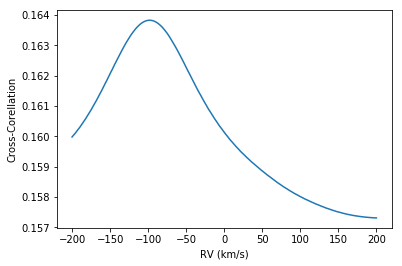

000.0000006 has Radial Velocity = -98
Shifting spectra 000.0000006 to rest frame
Normalizing spectra 000.0000006
Calculating weights...
Calculating continuum...
Continuum calculation complete!


/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


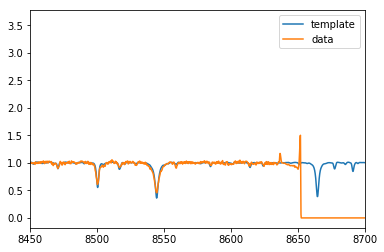

Processing spectra for object: spec1d.m15msk.001.0000014.fits
Restoring spectra #001.0000014
Interpolating spectra #001.0000014
Applying telluric mask for spectra 001.0000014
Finding radial velocity from CCF for spectra #001.0000014


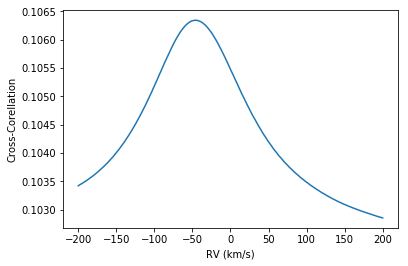

001.0000014 has Radial Velocity = -46
Shifting spectra 001.0000014 to rest frame
Normalizing spectra 001.0000014
Calculating weights...
Calculating continuum...
Continuum calculation complete!


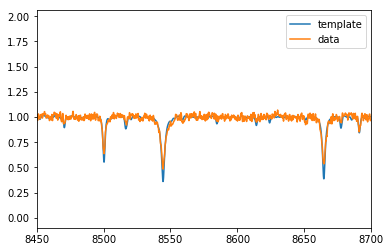

Processing spectra for object: spec1d.m15msk.002.0000019.fits
Restoring spectra #002.0000019
Interpolating spectra #002.0000019
Applying telluric mask for spectra 002.0000019
Finding radial velocity from CCF for spectra #002.0000019


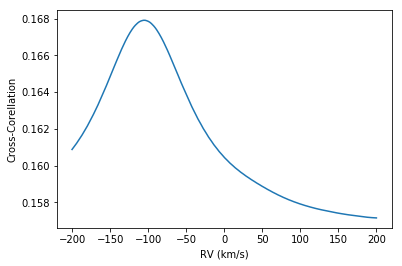

002.0000019 has Radial Velocity = -105
Shifting spectra 002.0000019 to rest frame
Normalizing spectra 002.0000019
Calculating weights...
Calculating continuum...
Continuum calculation complete!


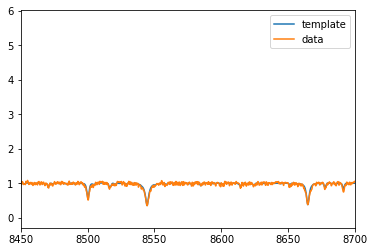

Processing spectra for object: spec1d.m15msk.003.0000023.fits
Restoring spectra #003.0000023
Interpolating spectra #003.0000023
Applying telluric mask for spectra 003.0000023
Finding radial velocity from CCF for spectra #003.0000023


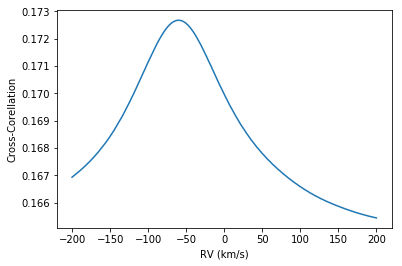

003.0000023 has Radial Velocity = -60
Shifting spectra 003.0000023 to rest frame
Normalizing spectra 003.0000023
Calculating weights...
Calculating continuum...
Continuum calculation complete!


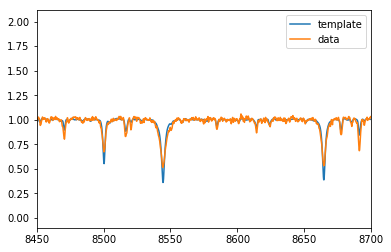

Processing spectra for object: spec1d.m15msk.004.0000029.fits
Restoring spectra #004.0000029
Interpolating spectra #004.0000029
Applying telluric mask for spectra 004.0000029
Finding radial velocity from CCF for spectra #004.0000029


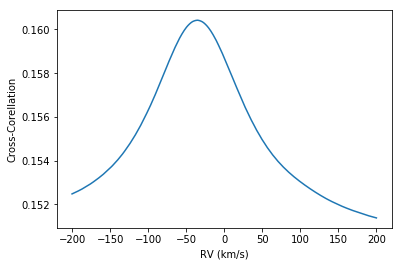

004.0000029 has Radial Velocity = -36
Shifting spectra 004.0000029 to rest frame
Normalizing spectra 004.0000029
Calculating weights...
Calculating continuum...
Continuum calculation complete!


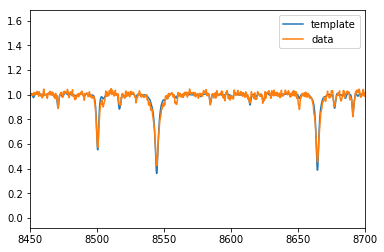

Processing spectra for object: spec1d.m15msk.005.0000030.fits
Restoring spectra #005.0000030
Interpolating spectra #005.0000030
Applying telluric mask for spectra 005.0000030
Finding radial velocity from CCF for spectra #005.0000030


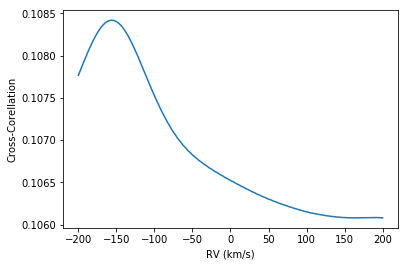

005.0000030 has Radial Velocity = -156
Shifting spectra 005.0000030 to rest frame
Normalizing spectra 005.0000030
Calculating weights...
Calculating continuum...
Continuum calculation complete!


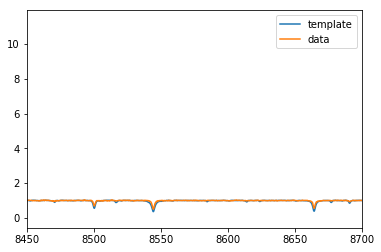

Processing spectra for object: spec1d.m15msk.006.0000031.fits
Restoring spectra #006.0000031
Interpolating spectra #006.0000031
Applying telluric mask for spectra 006.0000031
Finding radial velocity from CCF for spectra #006.0000031


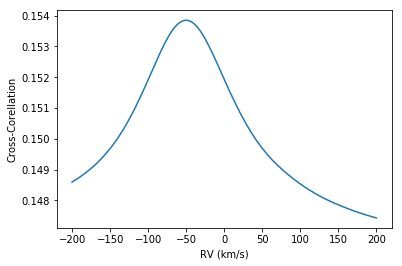

006.0000031 has Radial Velocity = -50
Shifting spectra 006.0000031 to rest frame
Normalizing spectra 006.0000031
Calculating weights...
Calculating continuum...
Continuum calculation complete!


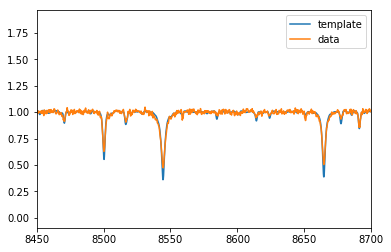

Processing spectra for object: spec1d.m15msk.007.0000034.fits
Restoring spectra #007.0000034
Interpolating spectra #007.0000034
Applying telluric mask for spectra 007.0000034
Finding radial velocity from CCF for spectra #007.0000034


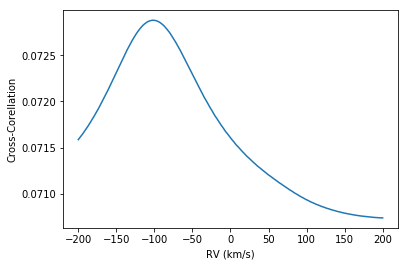

007.0000034 has Radial Velocity = -102
Shifting spectra 007.0000034 to rest frame
Normalizing spectra 007.0000034
Calculating weights...
Calculating continuum...
Continuum calculation complete!


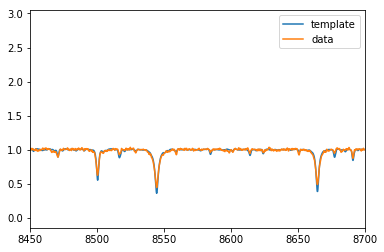

Processing spectra for object: spec1d.m15msk.008.0010337.fits
Restoring spectra #008.0010337
Interpolating spectra #008.0010337
Applying telluric mask for spectra 008.0010337
Finding radial velocity from CCF for spectra #008.0010337


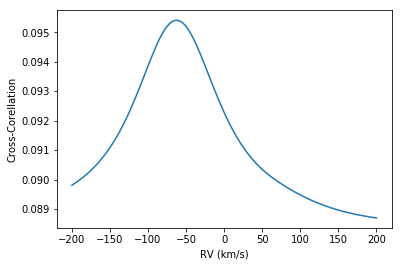

008.0010337 has Radial Velocity = -63
Shifting spectra 008.0010337 to rest frame
Normalizing spectra 008.0010337
Calculating weights...
Calculating continuum...
Continuum calculation complete!


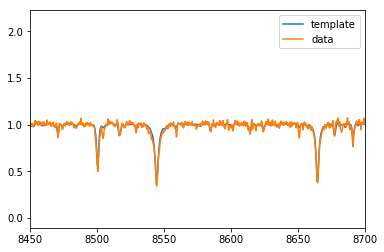

Processing spectra for object: spec1d.m15msk.008.serendip1.fits
Restoring spectra #008.serendip1
Interpolating spectra #008.serendip1
Applying telluric mask for spectra 008.serendip1
Finding radial velocity from CCF for spectra #008.serendip1


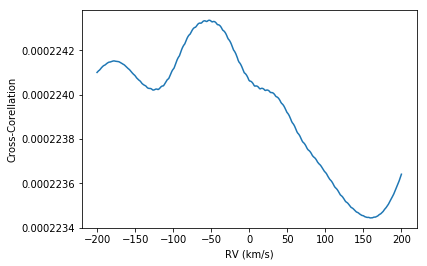

008.serendip1 has Radial Velocity = -53
Shifting spectra 008.serendip1 to rest frame
Normalizing spectra 008.serendip1
Calculating weights...
Calculating continuum...
Continuum calculation complete!


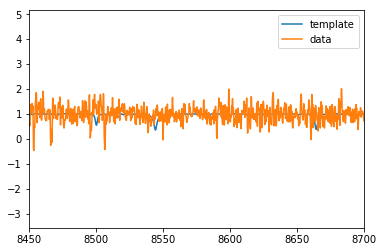

Processing spectra for object: spec1d.m15msk.009.0010230.fits
Restoring spectra #009.0010230
Interpolating spectra #009.0010230
Applying telluric mask for spectra 009.0010230
Finding radial velocity from CCF for spectra #009.0010230


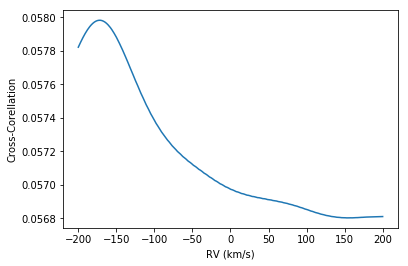

009.0010230 has Radial Velocity = -172
Shifting spectra 009.0010230 to rest frame
Normalizing spectra 009.0010230
Calculating weights...
Calculating continuum...
Continuum calculation complete!


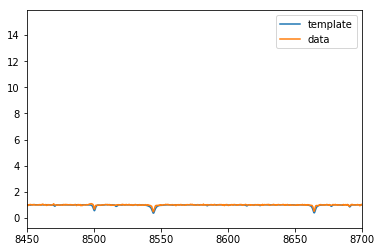

Processing spectra for object: spec1d.m15msk.010.0010510.fits
Restoring spectra #010.0010510
Interpolating spectra #010.0010510
Applying telluric mask for spectra 010.0010510
Finding radial velocity from CCF for spectra #010.0010510


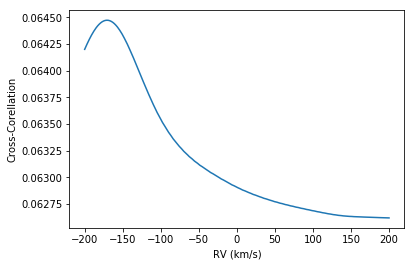

010.0010510 has Radial Velocity = -171
Shifting spectra 010.0010510 to rest frame
Normalizing spectra 010.0010510
Calculating weights...
Calculating continuum...
Continuum calculation complete!


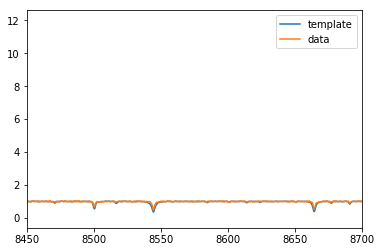

Processing spectra for object: spec1d.m15msk.011.0010572.fits
Restoring spectra #011.0010572
Interpolating spectra #011.0010572
Applying telluric mask for spectra 011.0010572
Finding radial velocity from CCF for spectra #011.0010572


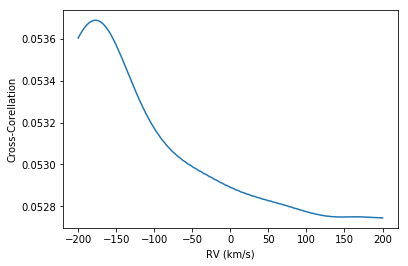

011.0010572 has Radial Velocity = -177
Shifting spectra 011.0010572 to rest frame
Normalizing spectra 011.0010572
Calculating weights...
Calculating continuum...
Continuum calculation complete!


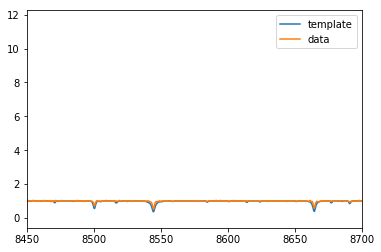

Processing spectra for object: spec1d.m15msk.012.0010152.fits
Restoring spectra #012.0010152
Interpolating spectra #012.0010152
Applying telluric mask for spectra 012.0010152
Finding radial velocity from CCF for spectra #012.0010152


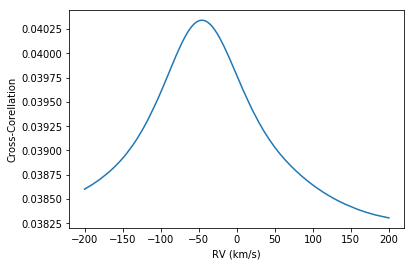

012.0010152 has Radial Velocity = -46
Shifting spectra 012.0010152 to rest frame
Normalizing spectra 012.0010152
Calculating weights...
Calculating continuum...
Continuum calculation complete!


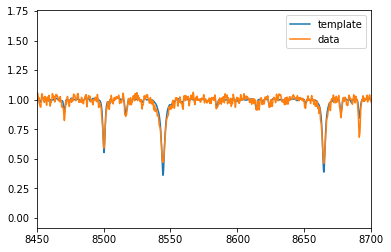

Processing spectra for object: spec1d.m15msk.013.0010541.fits
Restoring spectra #013.0010541
Interpolating spectra #013.0010541
Applying telluric mask for spectra 013.0010541
Finding radial velocity from CCF for spectra #013.0010541


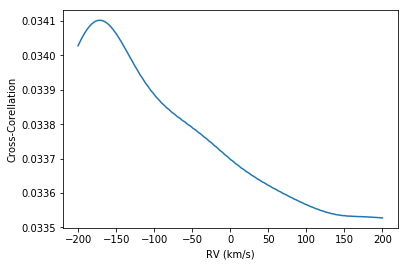

013.0010541 has Radial Velocity = -171
Shifting spectra 013.0010541 to rest frame
Normalizing spectra 013.0010541
Calculating weights...
Calculating continuum...
Continuum calculation complete!


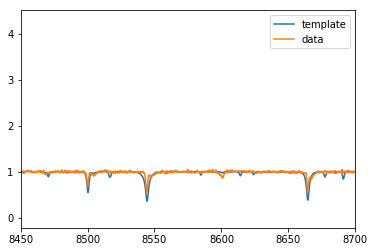

Processing spectra for object: spec1d.m15msk.013.serendip1.fits
Restoring spectra #013.serendip1
Interpolating spectra #013.serendip1
Applying telluric mask for spectra 013.serendip1
Finding radial velocity from CCF for spectra #013.serendip1


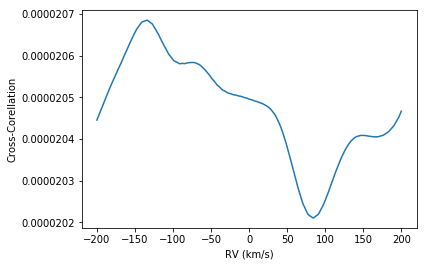

013.serendip1 has Radial Velocity = -134
Shifting spectra 013.serendip1 to rest frame
Normalizing spectra 013.serendip1
Calculating weights...
Calculating continuum...
Continuum calculation complete!


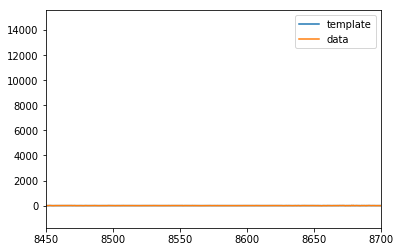

Processing spectra for object: spec1d.m15msk.014.0010260.fits
Restoring spectra #014.0010260
Interpolating spectra #014.0010260
Applying telluric mask for spectra 014.0010260
Finding radial velocity from CCF for spectra #014.0010260


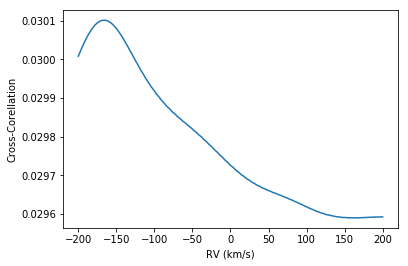

014.0010260 has Radial Velocity = -166
Shifting spectra 014.0010260 to rest frame
Normalizing spectra 014.0010260
Calculating weights...
Calculating continuum...
Continuum calculation complete!


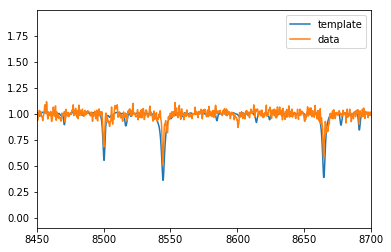

Processing spectra for object: spec1d.m15msk.015.0010330.fits
Restoring spectra #015.0010330
Interpolating spectra #015.0010330
Applying telluric mask for spectra 015.0010330
Finding radial velocity from CCF for spectra #015.0010330


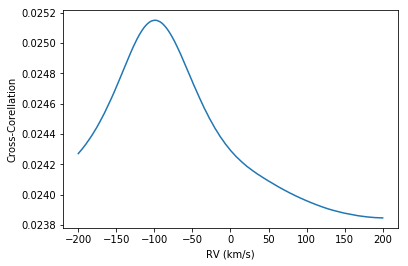

015.0010330 has Radial Velocity = -99
Shifting spectra 015.0010330 to rest frame
Normalizing spectra 015.0010330
Calculating weights...
Calculating continuum...
Continuum calculation complete!


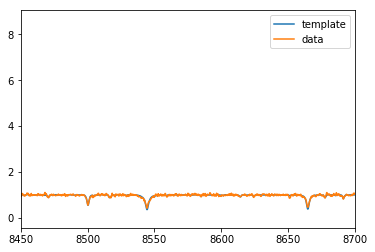

Processing spectra for object: spec1d.m15msk.015.serendip1.fits
Restoring spectra #015.serendip1
Interpolating spectra #015.serendip1
Applying telluric mask for spectra 015.serendip1
Finding radial velocity from CCF for spectra #015.serendip1


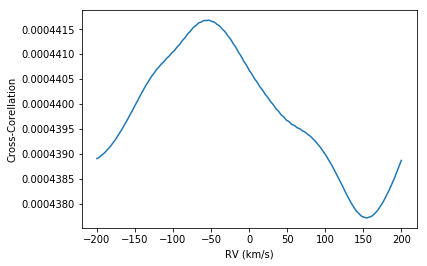

015.serendip1 has Radial Velocity = -54
Shifting spectra 015.serendip1 to rest frame
Normalizing spectra 015.serendip1
Calculating weights...
Calculating continuum...
Continuum calculation complete!


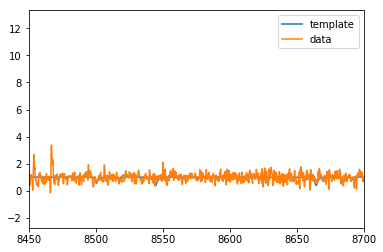

Processing spectra for object: spec1d.m15msk.015.serendip2.fits
Restoring spectra #015.serendip2
Interpolating spectra #015.serendip2
Applying telluric mask for spectra 015.serendip2
Finding radial velocity from CCF for spectra #015.serendip2


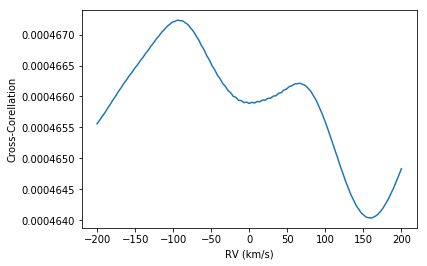

015.serendip2 has Radial Velocity = -94
Shifting spectra 015.serendip2 to rest frame
Normalizing spectra 015.serendip2
Calculating weights...
Calculating continuum...
Continuum calculation complete!


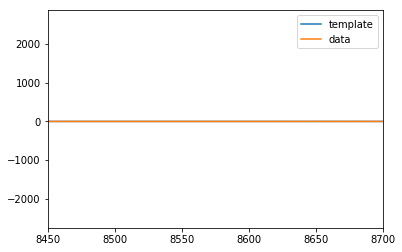

Processing spectra for object: spec1d.m15msk.016.0010294.fits
Restoring spectra #016.0010294
Interpolating spectra #016.0010294
Applying telluric mask for spectra 016.0010294
Finding radial velocity from CCF for spectra #016.0010294


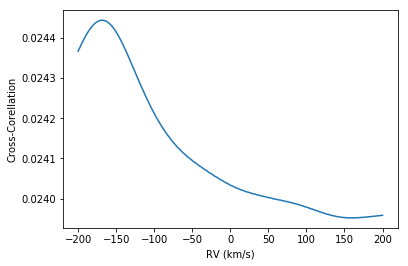

016.0010294 has Radial Velocity = -169
Shifting spectra 016.0010294 to rest frame
Normalizing spectra 016.0010294
Calculating weights...
Calculating continuum...
Continuum calculation complete!


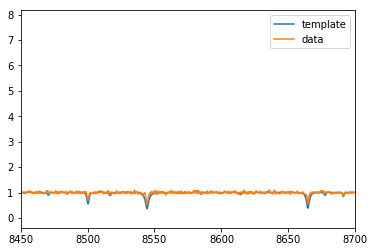

Processing spectra for object: spec1d.m15msk.016.serendip1.fits
Restoring spectra #016.serendip1
Interpolating spectra #016.serendip1
Applying telluric mask for spectra 016.serendip1
Finding radial velocity from CCF for spectra #016.serendip1


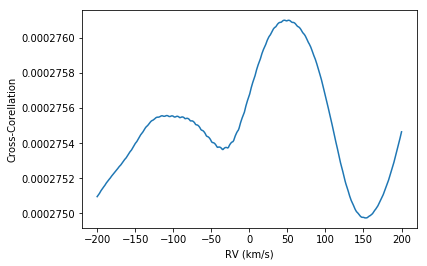

016.serendip1 has Radial Velocity = 47
Shifting spectra 016.serendip1 to rest frame
Normalizing spectra 016.serendip1
Calculating weights...
Calculating continuum...
Continuum calculation complete!


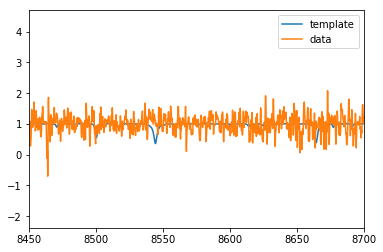

Processing spectra for object: spec1d.m15msk.017.0010244.fits
Restoring spectra #017.0010244
Interpolating spectra #017.0010244
Applying telluric mask for spectra 017.0010244
Finding radial velocity from CCF for spectra #017.0010244


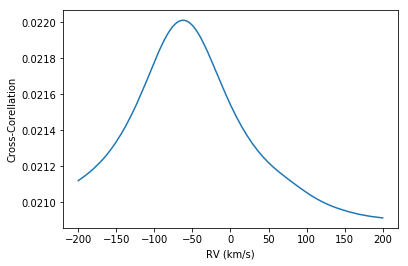

017.0010244 has Radial Velocity = -63
Shifting spectra 017.0010244 to rest frame
Normalizing spectra 017.0010244
Calculating weights...
Calculating continuum...
Continuum calculation complete!


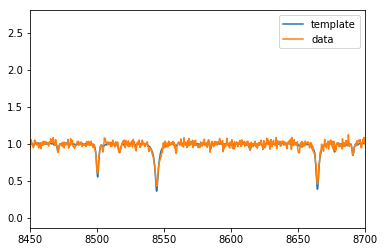

Processing spectra for object: spec1d.m15msk.018.0010217.fits
Restoring spectra #018.0010217
Interpolating spectra #018.0010217
Applying telluric mask for spectra 018.0010217
Finding radial velocity from CCF for spectra #018.0010217


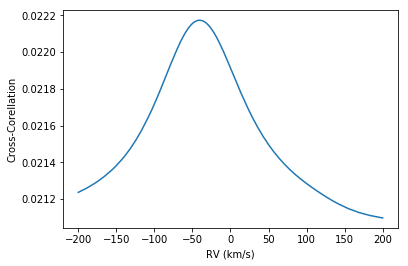

018.0010217 has Radial Velocity = -42
Shifting spectra 018.0010217 to rest frame
Normalizing spectra 018.0010217
Calculating weights...
Calculating continuum...
Continuum calculation complete!


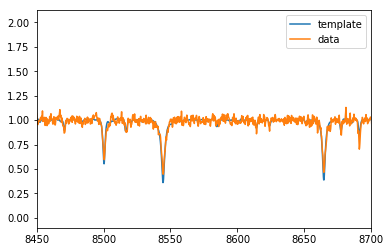

Processing spectra for object: spec1d.m15msk.018.serendip1.fits
Restoring spectra #018.serendip1
Interpolating spectra #018.serendip1
Applying telluric mask for spectra 018.serendip1
Finding radial velocity from CCF for spectra #018.serendip1


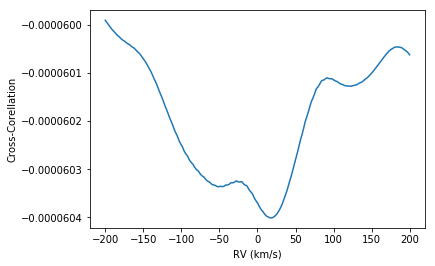

018.serendip1 has Radial Velocity = -200
Shifting spectra 018.serendip1 to rest frame
Normalizing spectra 018.serendip1
Calculating weights...
Calculating continuum...
Continuum calculation complete!


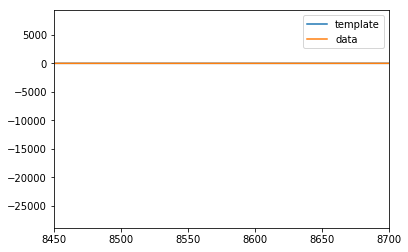

Processing spectra for object: spec1d.m15msk.019.0010495.fits
Restoring spectra #019.0010495
Interpolating spectra #019.0010495
Applying telluric mask for spectra 019.0010495
Finding radial velocity from CCF for spectra #019.0010495


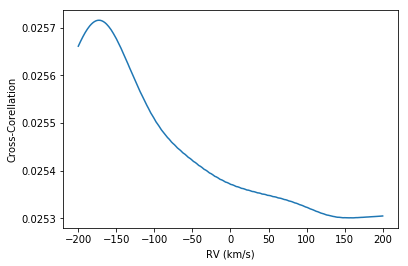

019.0010495 has Radial Velocity = -173
Shifting spectra 019.0010495 to rest frame
Normalizing spectra 019.0010495
Calculating weights...
Calculating continuum...
Continuum calculation complete!


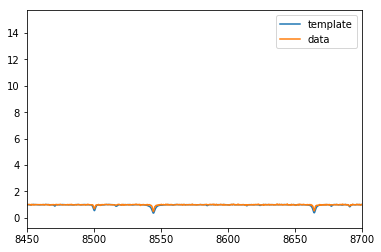

Processing spectra for object: spec1d.m15msk.020.0010068.fits
Restoring spectra #020.0010068
Interpolating spectra #020.0010068
Applying telluric mask for spectra 020.0010068
Finding radial velocity from CCF for spectra #020.0010068


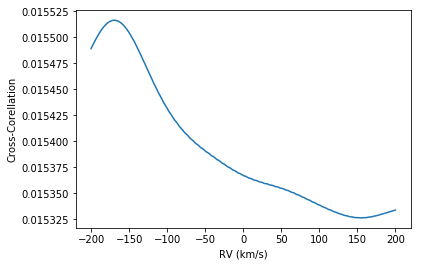

020.0010068 has Radial Velocity = -170
Shifting spectra 020.0010068 to rest frame
Normalizing spectra 020.0010068
Calculating weights...
Calculating continuum...
Continuum calculation complete!


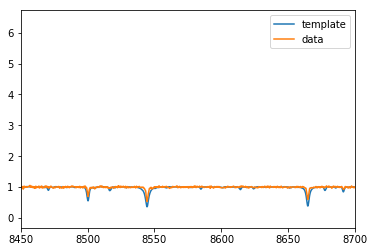

Processing spectra for object: spec1d.m15msk.021.0010093.fits
Restoring spectra #021.0010093
Interpolating spectra #021.0010093
Applying telluric mask for spectra 021.0010093
Finding radial velocity from CCF for spectra #021.0010093


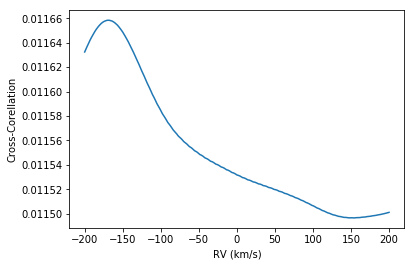

021.0010093 has Radial Velocity = -169
Shifting spectra 021.0010093 to rest frame
Normalizing spectra 021.0010093
Calculating weights...
Calculating continuum...
Continuum calculation complete!


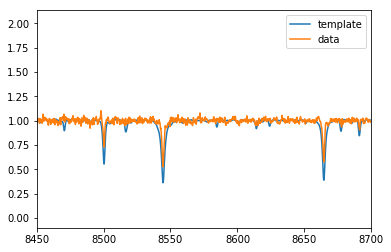

Processing spectra for object: spec1d.m15msk.022.0010191.fits
Restoring spectra #022.0010191
Interpolating spectra #022.0010191
Applying telluric mask for spectra 022.0010191
Finding radial velocity from CCF for spectra #022.0010191


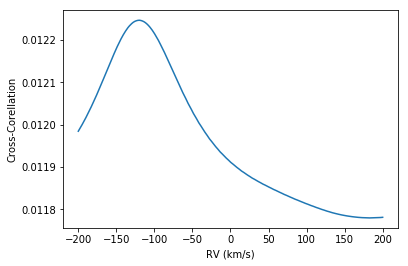

022.0010191 has Radial Velocity = -120
Shifting spectra 022.0010191 to rest frame
Normalizing spectra 022.0010191
Calculating weights...
Calculating continuum...
Continuum calculation complete!


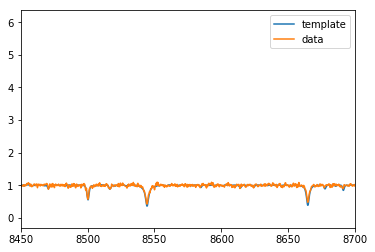

Processing spectra for object: spec1d.m15msk.023.0010550.fits
Restoring spectra #023.0010550
Interpolating spectra #023.0010550
Applying telluric mask for spectra 023.0010550
Finding radial velocity from CCF for spectra #023.0010550


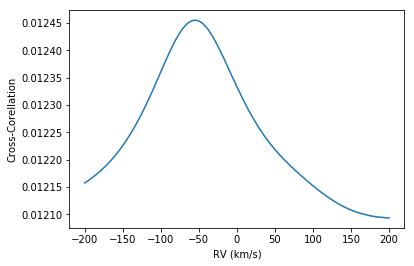

023.0010550 has Radial Velocity = -55
Shifting spectra 023.0010550 to rest frame
Normalizing spectra 023.0010550
Calculating weights...
Calculating continuum...
Continuum calculation complete!


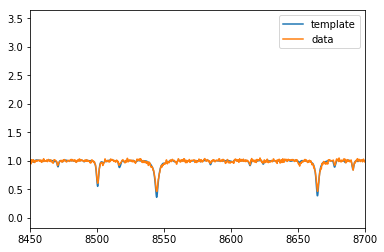

Processing spectra for object: spec1d.m15msk.024.0010453.fits
Restoring spectra #024.0010453
Interpolating spectra #024.0010453
Applying telluric mask for spectra 024.0010453
Finding radial velocity from CCF for spectra #024.0010453


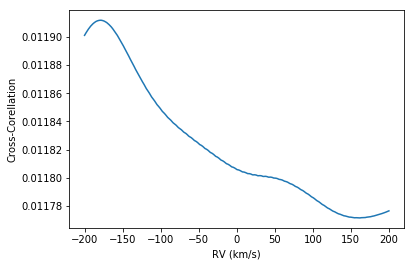

024.0010453 has Radial Velocity = -179
Shifting spectra 024.0010453 to rest frame
Normalizing spectra 024.0010453
Calculating weights...
Calculating continuum...
Continuum calculation complete!


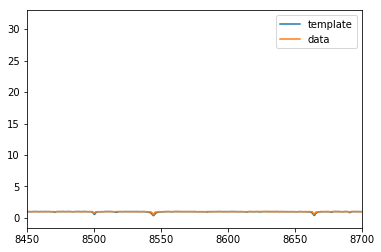

Processing spectra for object: spec1d.m15msk.024.serendip1.fits
Restoring spectra #024.serendip1
Interpolating spectra #024.serendip1
Applying telluric mask for spectra 024.serendip1
Finding radial velocity from CCF for spectra #024.serendip1


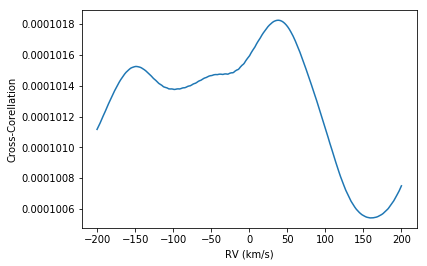

024.serendip1 has Radial Velocity = 38
Shifting spectra 024.serendip1 to rest frame
Normalizing spectra 024.serendip1
Calculating weights...
Calculating continuum...
Continuum calculation complete!


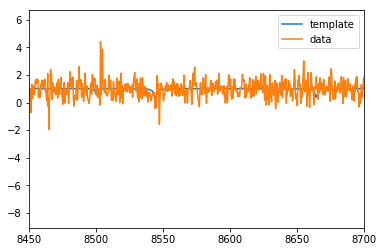

Processing spectra for object: spec1d.m15msk.024.serendip2.fits
Restoring spectra #024.serendip2
Interpolating spectra #024.serendip2
Applying telluric mask for spectra 024.serendip2
Finding radial velocity from CCF for spectra #024.serendip2


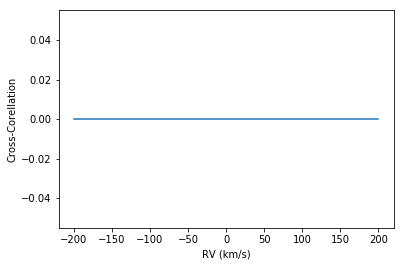

024.serendip2 has Radial Velocity = -200
Shifting spectra 024.serendip2 to rest frame
Normalizing spectra 024.serendip2
Calculating weights...
Calculating continuum...
Continuum calculation complete!


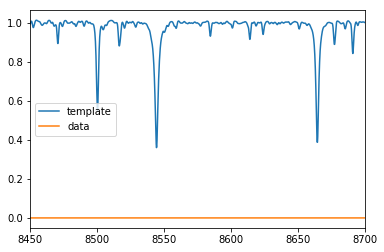

Processing spectra for object: spec1d.m15msk.025.0010581.fits
Restoring spectra #025.0010581
Interpolating spectra #025.0010581
Applying telluric mask for spectra 025.0010581
Finding radial velocity from CCF for spectra #025.0010581


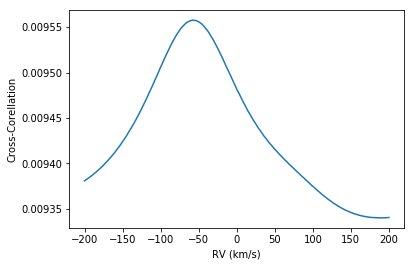

025.0010581 has Radial Velocity = -58
Shifting spectra 025.0010581 to rest frame
Normalizing spectra 025.0010581
Calculating weights...
Calculating continuum...
Continuum calculation complete!


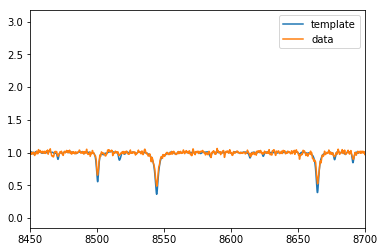

Processing spectra for object: spec1d.m15msk.026.0010272.fits
Restoring spectra #026.0010272
Interpolating spectra #026.0010272
Applying telluric mask for spectra 026.0010272
Finding radial velocity from CCF for spectra #026.0010272


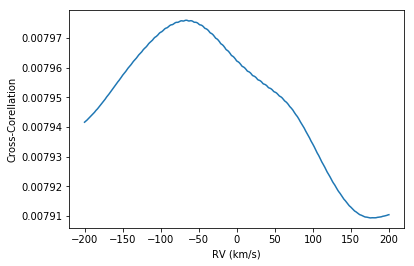

026.0010272 has Radial Velocity = -67
Shifting spectra 026.0010272 to rest frame
Normalizing spectra 026.0010272
Calculating weights...
Calculating continuum...
Continuum calculation complete!


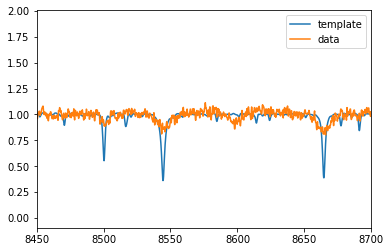

Processing spectra for object: spec1d.m15msk.027.0010577.fits
Restoring spectra #027.0010577
Interpolating spectra #027.0010577
Applying telluric mask for spectra 027.0010577
Finding radial velocity from CCF for spectra #027.0010577


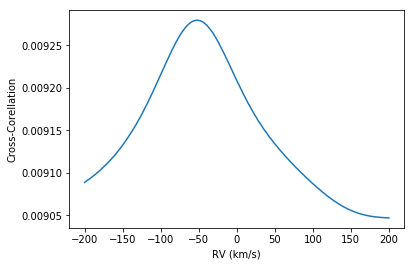

027.0010577 has Radial Velocity = -52
Shifting spectra 027.0010577 to rest frame
Normalizing spectra 027.0010577
Calculating weights...
Calculating continuum...
Continuum calculation complete!


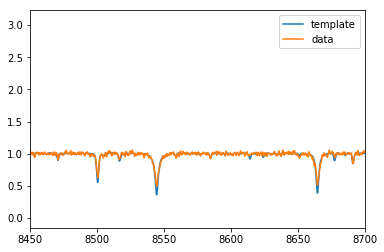

Processing spectra for object: spec1d.m15msk.027.serendip1.fits
Restoring spectra #027.serendip1
Interpolating spectra #027.serendip1
Applying telluric mask for spectra 027.serendip1
Finding radial velocity from CCF for spectra #027.serendip1


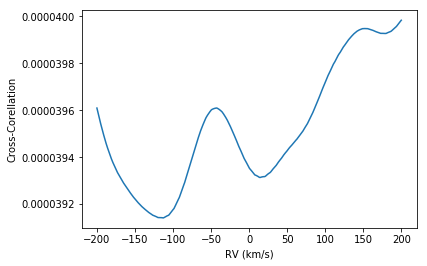

027.serendip1 has Radial Velocity = 200
Shifting spectra 027.serendip1 to rest frame
Normalizing spectra 027.serendip1
Calculating weights...
Calculating continuum...
Continuum calculation complete!


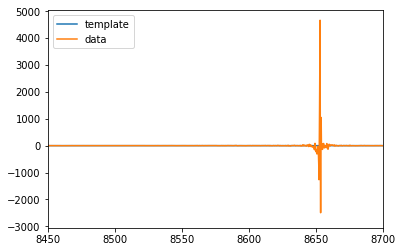

Processing spectra for object: spec1d.m15msk.028.0010147.fits
Restoring spectra #028.0010147
Interpolating spectra #028.0010147
Applying telluric mask for spectra 028.0010147
Finding radial velocity from CCF for spectra #028.0010147


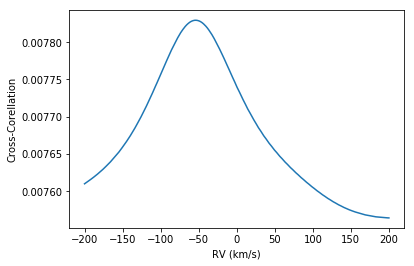

028.0010147 has Radial Velocity = -54
Shifting spectra 028.0010147 to rest frame
Normalizing spectra 028.0010147
Calculating weights...
Calculating continuum...
Continuum calculation complete!


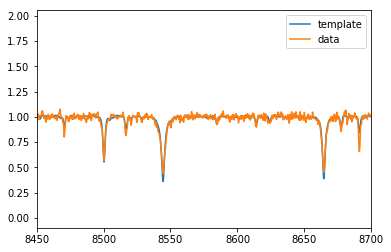

Processing spectra for object: spec1d.m15msk.029.0010195.fits
Restoring spectra #029.0010195
Interpolating spectra #029.0010195
Applying telluric mask for spectra 029.0010195
Finding radial velocity from CCF for spectra #029.0010195


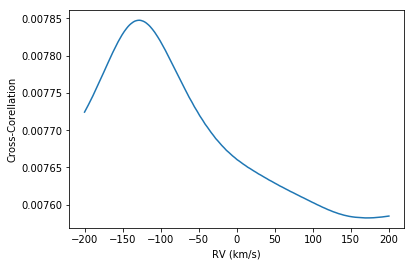

029.0010195 has Radial Velocity = -128
Shifting spectra 029.0010195 to rest frame
Normalizing spectra 029.0010195
Calculating weights...
Calculating continuum...
Continuum calculation complete!


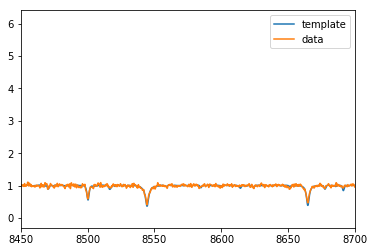

Processing spectra for object: spec1d.m15msk.029.serendip1.fits
Restoring spectra #029.serendip1
Interpolating spectra #029.serendip1
Applying telluric mask for spectra 029.serendip1
Finding radial velocity from CCF for spectra #029.serendip1


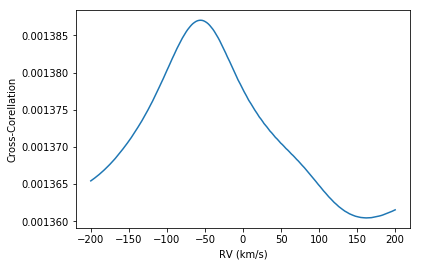

029.serendip1 has Radial Velocity = -56
Shifting spectra 029.serendip1 to rest frame
Normalizing spectra 029.serendip1
Calculating weights...
Calculating continuum...
Continuum calculation complete!


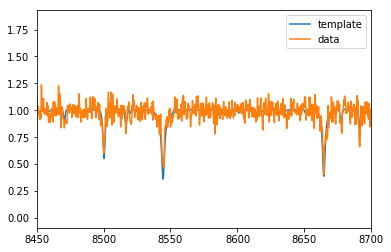

Processing spectra for object: spec1d.m15msk.030.0010442.fits
Restoring spectra #030.0010442
Interpolating spectra #030.0010442
Applying telluric mask for spectra 030.0010442
Finding radial velocity from CCF for spectra #030.0010442


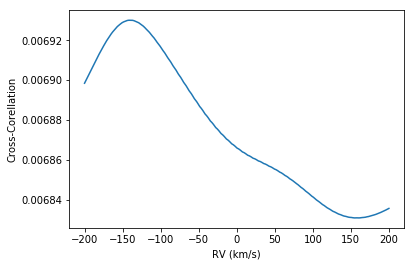

030.0010442 has Radial Velocity = -142
Shifting spectra 030.0010442 to rest frame
Normalizing spectra 030.0010442
Calculating weights...
Calculating continuum...
Continuum calculation complete!


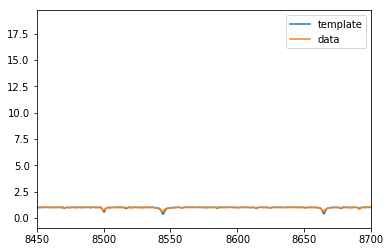

Processing spectra for object: spec1d.m15msk.030.serendip1.fits
Restoring spectra #030.serendip1
Interpolating spectra #030.serendip1
Applying telluric mask for spectra 030.serendip1
Finding radial velocity from CCF for spectra #030.serendip1


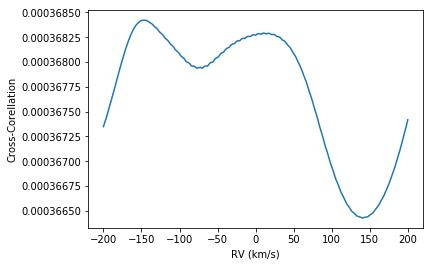

030.serendip1 has Radial Velocity = -146
Shifting spectra 030.serendip1 to rest frame
Normalizing spectra 030.serendip1
Calculating weights...
Calculating continuum...
Continuum calculation complete!


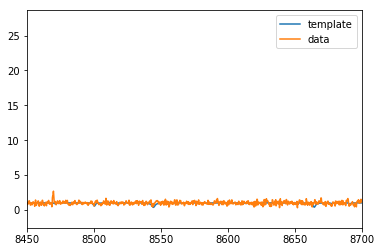

Processing spectra for object: spec1d.m15msk.031.0010425.fits
Restoring spectra #031.0010425
Interpolating spectra #031.0010425
Applying telluric mask for spectra 031.0010425
Finding radial velocity from CCF for spectra #031.0010425


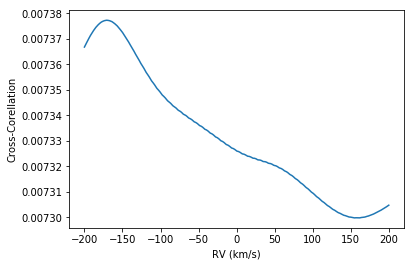

031.0010425 has Radial Velocity = -171
Shifting spectra 031.0010425 to rest frame
Normalizing spectra 031.0010425
Calculating weights...
Calculating continuum...
Continuum calculation complete!


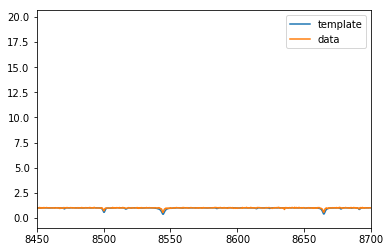

Processing spectra for object: spec1d.m15msk.031.serendip1.fits
Restoring spectra #031.serendip1
Interpolating spectra #031.serendip1
Applying telluric mask for spectra 031.serendip1
Finding radial velocity from CCF for spectra #031.serendip1


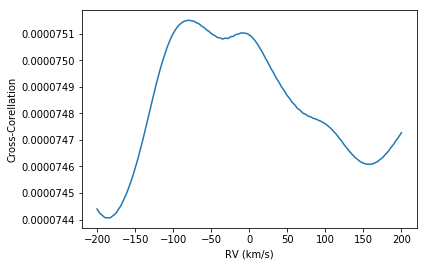

031.serendip1 has Radial Velocity = -80
Shifting spectra 031.serendip1 to rest frame
Normalizing spectra 031.serendip1
Calculating weights...
Calculating continuum...
Continuum calculation complete!


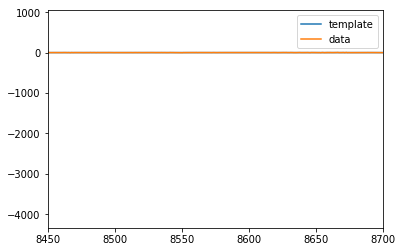

Processing spectra for object: spec1d.m15msk.031.serendip2.fits
Restoring spectra #031.serendip2
Interpolating spectra #031.serendip2
Applying telluric mask for spectra 031.serendip2
Finding radial velocity from CCF for spectra #031.serendip2


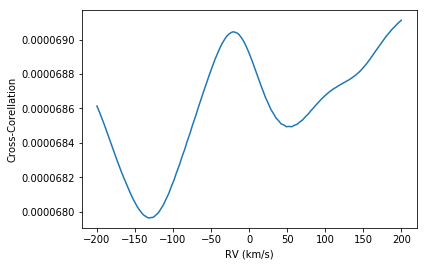

031.serendip2 has Radial Velocity = 200
Shifting spectra 031.serendip2 to rest frame
Normalizing spectra 031.serendip2
Calculating weights...
Calculating continuum...
Continuum calculation complete!


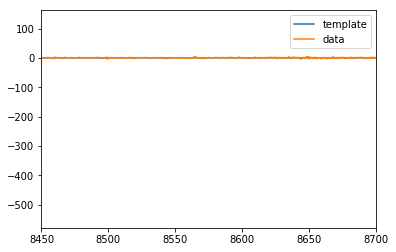

Processing spectra for object: spec1d.m15msk.032.0010123.fits
Restoring spectra #032.0010123
Interpolating spectra #032.0010123
Applying telluric mask for spectra 032.0010123
Finding radial velocity from CCF for spectra #032.0010123


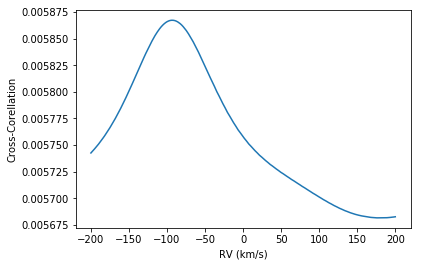

032.0010123 has Radial Velocity = -93
Shifting spectra 032.0010123 to rest frame
Normalizing spectra 032.0010123
Calculating weights...
Calculating continuum...
Continuum calculation complete!


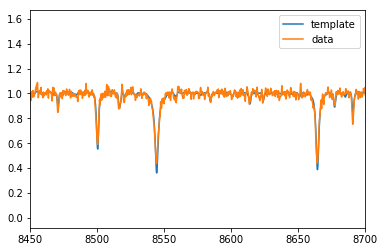

Processing spectra for object: spec1d.m15msk.033.0010107.fits
Restoring spectra #033.0010107
Interpolating spectra #033.0010107
Applying telluric mask for spectra 033.0010107
Finding radial velocity from CCF for spectra #033.0010107


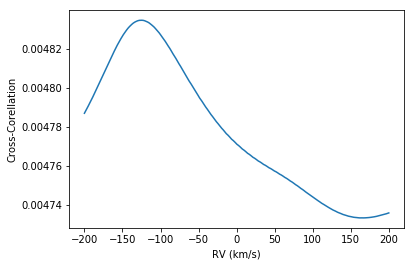

033.0010107 has Radial Velocity = -126
Shifting spectra 033.0010107 to rest frame
Normalizing spectra 033.0010107
Calculating weights...
Calculating continuum...
Continuum calculation complete!


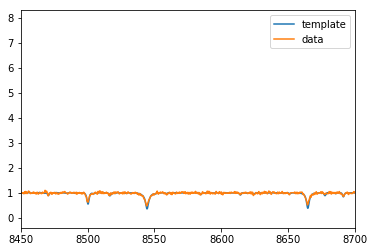

Processing spectra for object: spec1d.m15msk.034.0010494.fits
Restoring spectra #034.0010494
Interpolating spectra #034.0010494
Applying telluric mask for spectra 034.0010494
Finding radial velocity from CCF for spectra #034.0010494


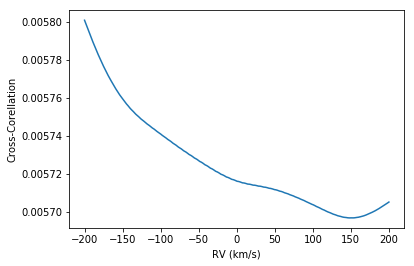

034.0010494 has Radial Velocity = -200
Shifting spectra 034.0010494 to rest frame
Normalizing spectra 034.0010494
Calculating weights...
Calculating continuum...
Continuum calculation complete!


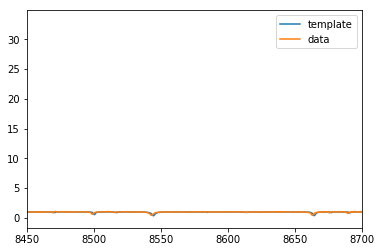

Processing spectra for object: spec1d.m15msk.035.0010452.fits
Restoring spectra #035.0010452
Interpolating spectra #035.0010452
Applying telluric mask for spectra 035.0010452
Finding radial velocity from CCF for spectra #035.0010452


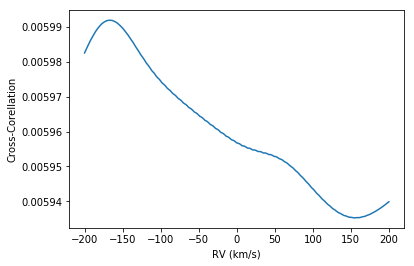

035.0010452 has Radial Velocity = -167
Shifting spectra 035.0010452 to rest frame
Normalizing spectra 035.0010452
Calculating weights...
Calculating continuum...
Continuum calculation complete!


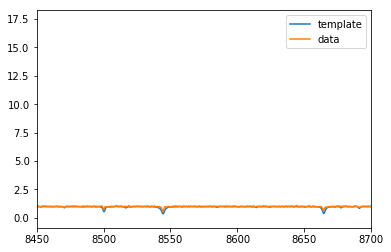

Processing spectra for object: spec1d.m15msk.035.serendip1.fits
Restoring spectra #035.serendip1
Interpolating spectra #035.serendip1
Applying telluric mask for spectra 035.serendip1
Finding radial velocity from CCF for spectra #035.serendip1


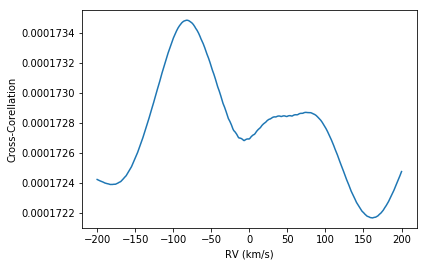

035.serendip1 has Radial Velocity = -82
Shifting spectra 035.serendip1 to rest frame
Normalizing spectra 035.serendip1
Calculating weights...
Calculating continuum...
Continuum calculation complete!


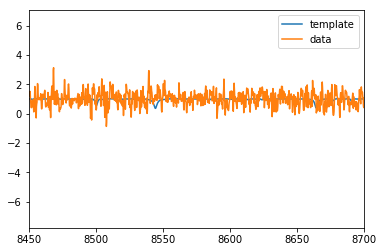

Processing spectra for object: spec1d.m15msk.036.0010207.fits
Restoring spectra #036.0010207
Interpolating spectra #036.0010207
Applying telluric mask for spectra 036.0010207
Finding radial velocity from CCF for spectra #036.0010207


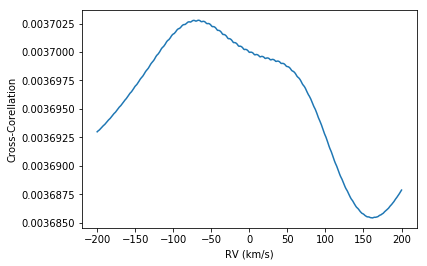

036.0010207 has Radial Velocity = -67
Shifting spectra 036.0010207 to rest frame
Normalizing spectra 036.0010207
Calculating weights...
Calculating continuum...
Continuum calculation complete!


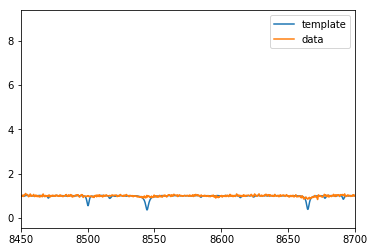

Processing spectra for object: spec1d.m15msk.036.serendip1.fits
Restoring spectra #036.serendip1
Interpolating spectra #036.serendip1
Applying telluric mask for spectra 036.serendip1
Finding radial velocity from CCF for spectra #036.serendip1


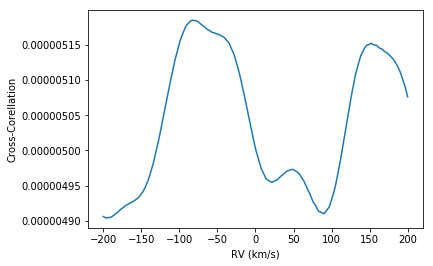

036.serendip1 has Radial Velocity = -83
Shifting spectra 036.serendip1 to rest frame
Normalizing spectra 036.serendip1
Calculating weights...
Calculating continuum...
Continuum calculation complete!


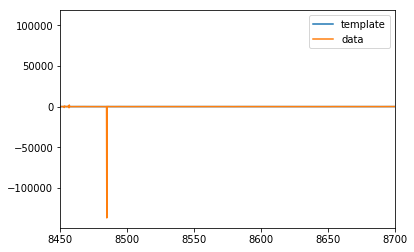

Processing spectra for object: spec1d.m15msk.037.0010066.fits
Restoring spectra #037.0010066
Interpolating spectra #037.0010066
Applying telluric mask for spectra 037.0010066
Finding radial velocity from CCF for spectra #037.0010066


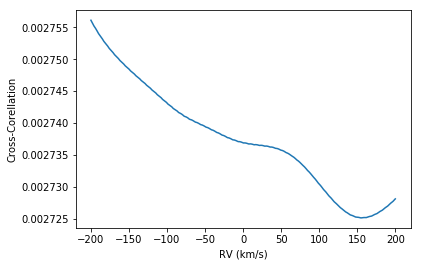

037.0010066 has Radial Velocity = -200
Shifting spectra 037.0010066 to rest frame
Normalizing spectra 037.0010066
Calculating weights...
Calculating continuum...
Continuum calculation complete!


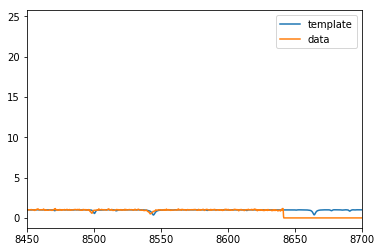

Processing spectra for object: spec1d.m15msk.037.serendip1.fits
Restoring spectra #037.serendip1
Interpolating spectra #037.serendip1
Applying telluric mask for spectra 037.serendip1
Finding radial velocity from CCF for spectra #037.serendip1


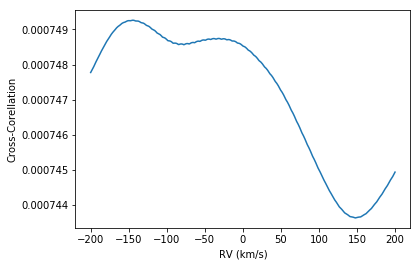

037.serendip1 has Radial Velocity = -145
Shifting spectra 037.serendip1 to rest frame
Normalizing spectra 037.serendip1
Calculating weights...
Calculating continuum...
Continuum calculation complete!


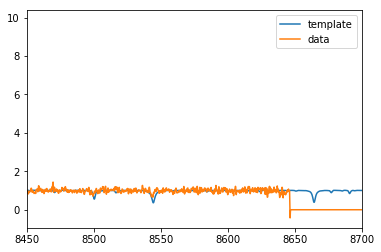

Processing spectra for object: spec1d.m15msk.038.0010176.fits
Restoring spectra #038.0010176
Interpolating spectra #038.0010176
Applying telluric mask for spectra 038.0010176
Finding radial velocity from CCF for spectra #038.0010176


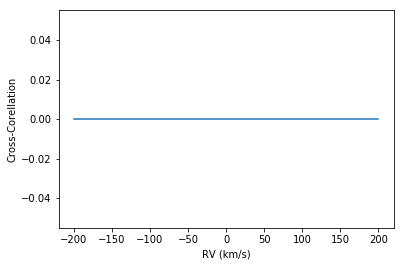

038.0010176 has Radial Velocity = -200
Shifting spectra 038.0010176 to rest frame
Normalizing spectra 038.0010176
Calculating weights...
Calculating continuum...
Continuum calculation complete!


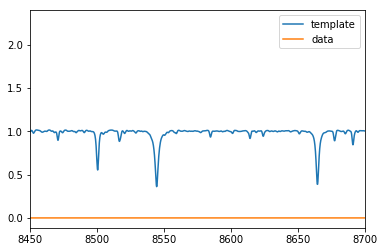

Processing spectra for object: spec1d.m15msk.038.serendip1.fits
Restoring spectra #038.serendip1
Interpolating spectra #038.serendip1
Applying telluric mask for spectra 038.serendip1
Finding radial velocity from CCF for spectra #038.serendip1


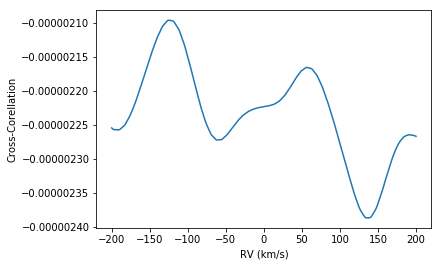

038.serendip1 has Radial Velocity = -125
Shifting spectra 038.serendip1 to rest frame
Normalizing spectra 038.serendip1
Calculating weights...
Calculating continuum...
Continuum calculation complete!


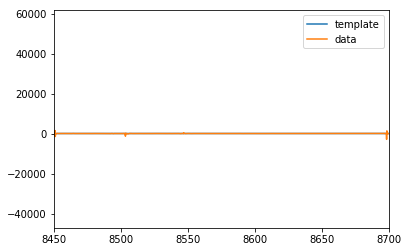

Processing spectra for object: spec1d.m15msk.039.0010405.fits
Restoring spectra #039.0010405
Interpolating spectra #039.0010405
Applying telluric mask for spectra 039.0010405
Finding radial velocity from CCF for spectra #039.0010405


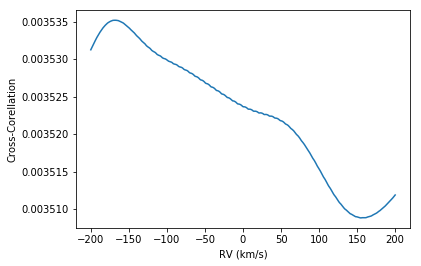

039.0010405 has Radial Velocity = -168
Shifting spectra 039.0010405 to rest frame
Normalizing spectra 039.0010405
Calculating weights...
Calculating continuum...
Continuum calculation complete!


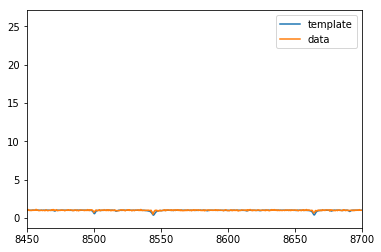

Processing spectra for object: spec1d.m15msk.039.serendip1.fits
Restoring spectra #039.serendip1
Interpolating spectra #039.serendip1
Applying telluric mask for spectra 039.serendip1
Finding radial velocity from CCF for spectra #039.serendip1


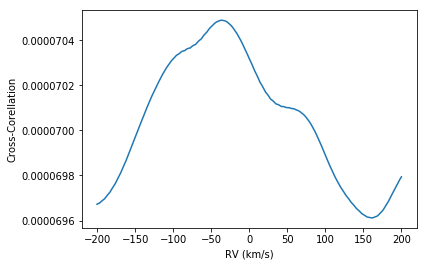

039.serendip1 has Radial Velocity = -37
Shifting spectra 039.serendip1 to rest frame
Normalizing spectra 039.serendip1
Calculating weights...
Calculating continuum...
Continuum calculation complete!


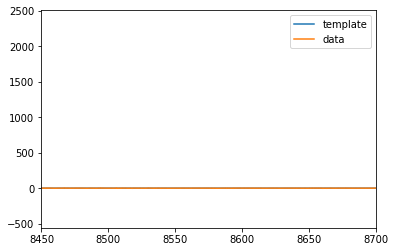

Processing spectra for object: spec1d.m15msk.040.0010487.fits
Restoring spectra #040.0010487
Interpolating spectra #040.0010487
Applying telluric mask for spectra 040.0010487
Finding radial velocity from CCF for spectra #040.0010487


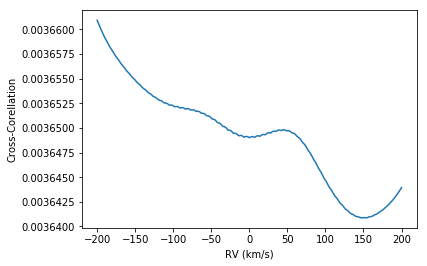

040.0010487 has Radial Velocity = -200
Shifting spectra 040.0010487 to rest frame
Normalizing spectra 040.0010487
Calculating weights...
Calculating continuum...
Continuum calculation complete!


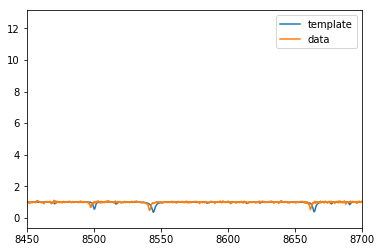

Processing spectra for object: spec1d.m15msk.040.serendip1.fits
Restoring spectra #040.serendip1
Interpolating spectra #040.serendip1
Applying telluric mask for spectra 040.serendip1
Finding radial velocity from CCF for spectra #040.serendip1


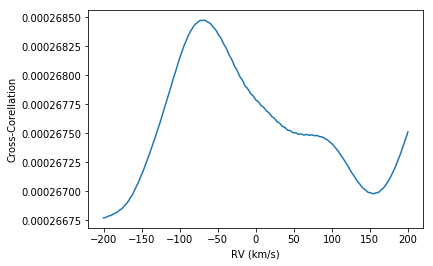

040.serendip1 has Radial Velocity = -68
Shifting spectra 040.serendip1 to rest frame
Normalizing spectra 040.serendip1
Calculating weights...
Calculating continuum...
Continuum calculation complete!


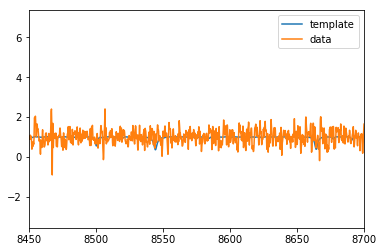

Processing spectra for object: spec1d.m15msk.041.0010215.fits
Restoring spectra #041.0010215
Interpolating spectra #041.0010215
Applying telluric mask for spectra 041.0010215
Finding radial velocity from CCF for spectra #041.0010215


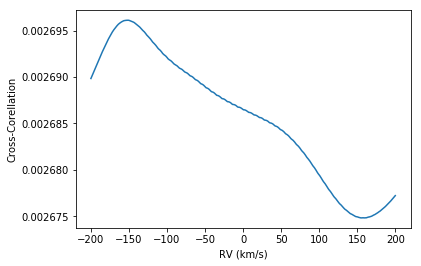

041.0010215 has Radial Velocity = -151
Shifting spectra 041.0010215 to rest frame
Normalizing spectra 041.0010215
Calculating weights...
Calculating continuum...
Continuum calculation complete!


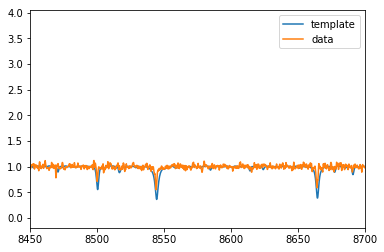

Processing spectra for object: spec1d.m15msk.042.0010526.fits
Restoring spectra #042.0010526
Interpolating spectra #042.0010526
Applying telluric mask for spectra 042.0010526
Finding radial velocity from CCF for spectra #042.0010526


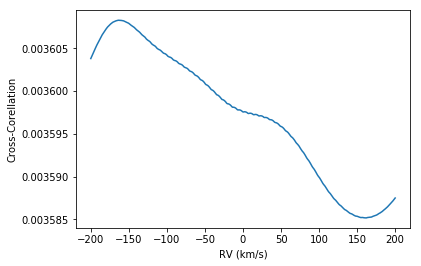

042.0010526 has Radial Velocity = -164
Shifting spectra 042.0010526 to rest frame
Normalizing spectra 042.0010526
Calculating weights...
Calculating continuum...
Continuum calculation complete!


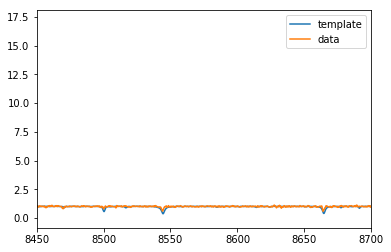

Processing spectra for object: spec1d.m15msk.043.0010525.fits
Restoring spectra #043.0010525
Interpolating spectra #043.0010525
Applying telluric mask for spectra 043.0010525
Finding radial velocity from CCF for spectra #043.0010525


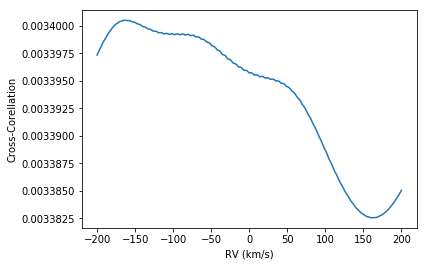

043.0010525 has Radial Velocity = -164
Shifting spectra 043.0010525 to rest frame
Normalizing spectra 043.0010525
Calculating weights...
Calculating continuum...


KeyboardInterrupt: 

In [16]:
for i in range(len(ObjList)):
    Obj = ObjList[i]
    ObjNumber = Obj[14:-5]
    print('Processing spectra for object: %s' % Obj)
    print('Restoring spectra #%s' % ObjNumber)
    wave_temp, spec_temp, ivar_temp, RA, Dec = \
        get_deimos_spectra(Obj=Obj, method=method, InputDir=InputDir)
        
    print('Interpolating spectra #%s' % ObjNumber)
    wavelength, spec, spec_err = \
        interpolate_deimos_spectra(wave=wave_temp,
                                   spec=spec_temp,
                                   spec_err=(ivar_temp**-1))
    print('Applying telluric mask for spectra %s' % ObjNumber)
    spec_err[mask] = 1e16
                                   
    print('Finding radial velocity from CCF for spectra #%s' % ObjNumber)
    dv = fast_RV(spec, spec_err, plot=True)
    print('%s has Radial Velocity = %.0f' % (ObjNumber,dv))
    print('Shifting spectra %s to rest frame' % ObjNumber)
    spec = utils.doppler_shift(wavelength=wavelength, flux=spec, dv=-dv)
    print('Normalizing spectra %s' % ObjNumber)
    cont_spec = \
        utils.get_deimos_continuum(spec, spec_err=spec_err,
                                   wavelength=wavelength,
                                   cont_pixels=cont_reg,
                                   wavelength_diff_matrix=wavelength_diff_matrix)
    spec = spec / cont_spec
    # Handle regions where continuum is zero
    spec_err[np.isnan(spec)] = 1e16
    spec[np.isnan(spec)] = 0
    
    plt.plot(wavelength_CaIItriplet,template_norm_spec,label='template')
    plt.plot(wavelength,spec,label='data')
    #plt.plot(wave,utils.doppler_shift(wave,template_norm_spec,dv),label='shifted template')
    plt.xlim(8450,8700)
    plt.legend()
    plt.show()